# Example with simulation data

On this page, we walk through how we might apply the functions from this package to data from a snapshot of a wind-tunnel numerical simulation. 

First, we load in the data

yt : [INFO     ] 2024-09-14 13:04:42,436 Parameters: current_time              = 7.5
yt : [INFO     ] 2024-09-14 13:04:42,436 Parameters: domain_dimensions         = [960 160 160]
yt : [INFO     ] 2024-09-14 13:04:42,437 Parameters: domain_left_edge          = [-60. -10. -10.]
yt : [INFO     ] 2024-09-14 13:04:42,437 Parameters: domain_right_edge         = [60. 10. 10.]
yt : [INFO     ] 2024-09-14 13:04:42,437 Parameters: cosmological_simulation   = 0
Parsing Hierarchy: 100%|███████████████████| 256/256 [00:00<00:00, 25694.98it/s]
yt : [INFO     ] 2024-09-14 13:04:43,439 Projection completed
yt : [INFO     ] 2024-09-14 13:04:43,441 xlim = -60.000000 60.000000
yt : [INFO     ] 2024-09-14 13:04:43,442 ylim = -10.000000 10.000000
yt : [INFO     ] 2024-09-14 13:04:43,443 xlim = -60.000000 60.000000
yt : [INFO     ] 2024-09-14 13:04:43,443 ylim = -10.000000 10.000000
yt : [INFO     ] 2024-09-14 13:04:43,445 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



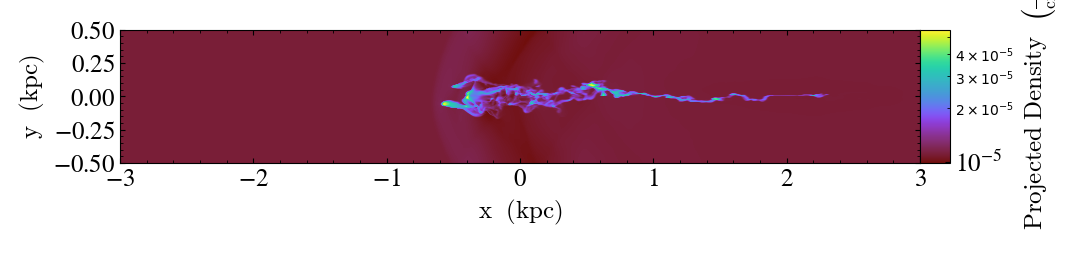

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pairstat import vsf_props, twopoint_correlation
import yt

path = (
    "../../../test_data/X100_M1.5_HD_CDdftCstr_R56.38_logP3_Res8/"
    "cloud_07.5000/cloud_07.5000.block_list"
)
ds = yt.load(path)
proj = yt.ProjectionPlot(ds, "z", ("gas", "density"))
proj.set_width([(6, "kpc"), (1, "kpc")])
proj

## Part 1: When the number of points is relatively small
First, we consider a scenario where we compute the VSF and 2PCF when the number of points is relatively small. We will compute properties for the cold phase of the gas. We might select information about the cold phase using logic like the following:

In [2]:
data = ds.all_data()
w = data["enzoe", "temperature"] <= 2e4

colder_pos = np.array(
    [data["index", ii][w].to("pc").ndarray_view() for ii in ["x", "y", "z"]]
)
colder_vel = np.array(
    [
        data["gas", "velocity_" + ii][w].to("km/s").ndarray_view()
        for ii in ["x", "y", "z"]
    ]
)
colder_dens = data["gas", "density"][w].to("g/cm**3").ndarray_view()

Down below, we plot the velocity structure function of this gas. In each panel, the vertical lines show the pixel scale and initial cloud radius.

The limited resolution (and the fact that we make no attempt to remove large scale velocity gradients) limits what we can actually say about turbulence from these figures, but this illustrates how the program can be used for analyzing simulations.
[Abruzzo et al. 2024](https://ui.adsabs.harvard.edu/abs/2024ApJ...966..181A/abstract) illustrates that with some additional care (and higher resolution) you can capture more information about the simulations with these types of statistics.

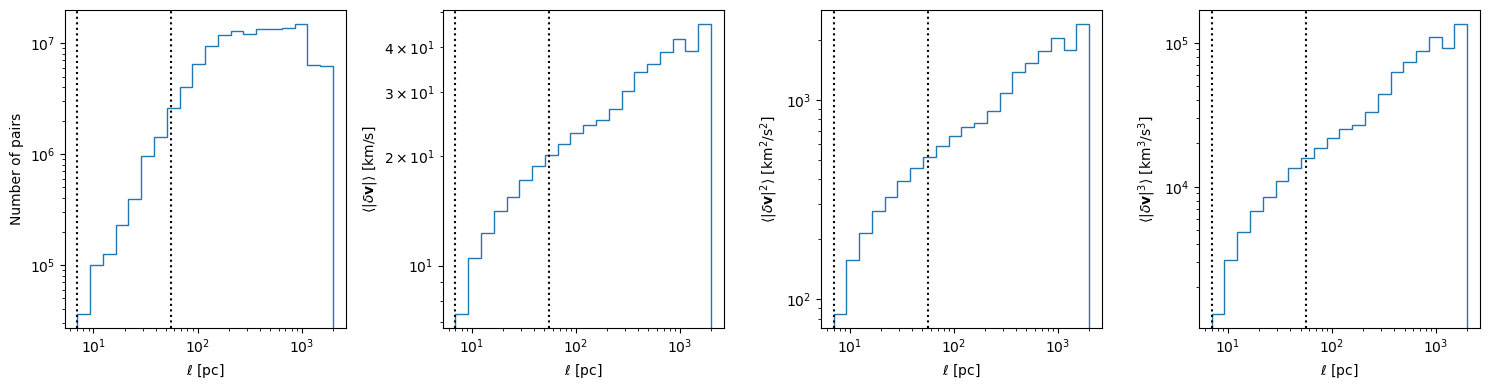

In [3]:
dist_bin_edges = np.geomspace(7.0, 2000.0, num=21)

result_dict = vsf_props(
    pos_a=colder_pos,
    pos_b=None,
    val_a=colder_vel,
    val_b=None,
    dist_bin_edges=dist_bin_edges,
    stat_kw_pairs=[("omoment3", {})],
    nproc=1,
)[0]


fig, ax_arr = plt.subplots(1, 4, figsize=(15, 4), sharex=True)

ax_arr[0].stairs(result_dict["counts"], edges=dist_bin_edges)
ax_arr[0].set_ylabel("Number of pairs")
ax_arr[1].stairs(result_dict["mean"], edges=dist_bin_edges)
ax_arr[1].set_ylabel(r"$\langle|\delta{\bf v}|\rangle$ [${\rm km}/{\rm s}$]")
ax_arr[2].stairs(result_dict["omoment2"], edges=dist_bin_edges)
ax_arr[2].set_ylabel(r"$\langle|\delta{\bf v}|^2\rangle$ [${\rm km}^2/{\rm s}^2$]")
ax_arr[3].stairs(result_dict["omoment3"], edges=dist_bin_edges)
ax_arr[3].set_ylabel(r"$\langle|\delta{\bf v}|^3\rangle$ [${\rm km}^3/{\rm s}^3$]")

for ax in ax_arr:
    ax.set_xlabel(r"$\ell\ [{\rm pc}]$")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.axvline(56, ls=":", color="k", label="initial radius")
    ax.axvline(56 / 8, ls=":", color="k", label="pixel scale")

fig.tight_layout()

And now, we plot the two-point correlation function for the density field

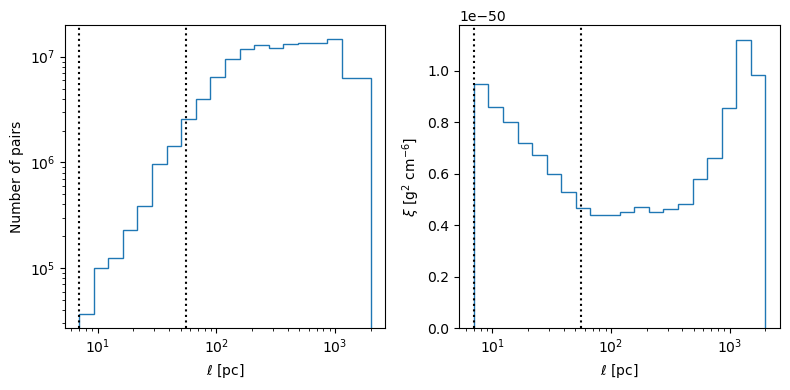

In [4]:
corr_result_dict = twopoint_correlation(
    pos_a=colder_pos,
    val_a=colder_dens,
    pos_b=None,
    val_b=None,
    dist_bin_edges=dist_bin_edges,
    stat_kw_pairs=[("mean", {})],
    nproc=1,
)[0]

fig, ax_arr = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

ax_arr[0].stairs(corr_result_dict["counts"], edges=dist_bin_edges)
ax_arr[0].set_ylabel("Number of pairs")
ax_arr[0].set_yscale("log")
ax_arr[1].stairs(corr_result_dict["mean"], edges=dist_bin_edges)
ax_arr[1].set_ylabel(r"$\xi\ [{\rm g}^2\ {\rm cm}^{-6}]$ ")

for ax in ax_arr:
    ax.set_xlabel(r"$\ell\ [{\rm pc}]$")
    ax.set_xscale("log")
    ax.axvline(56, ls=":", color="k", label="initial radius")
    ax.axvline(56 / 8, ls=":", color="k", label="pixel scale")

fig.tight_layout()

## Part 2: When the number of points is large (random sampling)

Now, we show an example of how you might use the functionality provided by this module with random sampling in a scenario where the number of pairs of points is very high. In this case, we consider the vsf and  for all gas in the simulation.

(3, 100000)


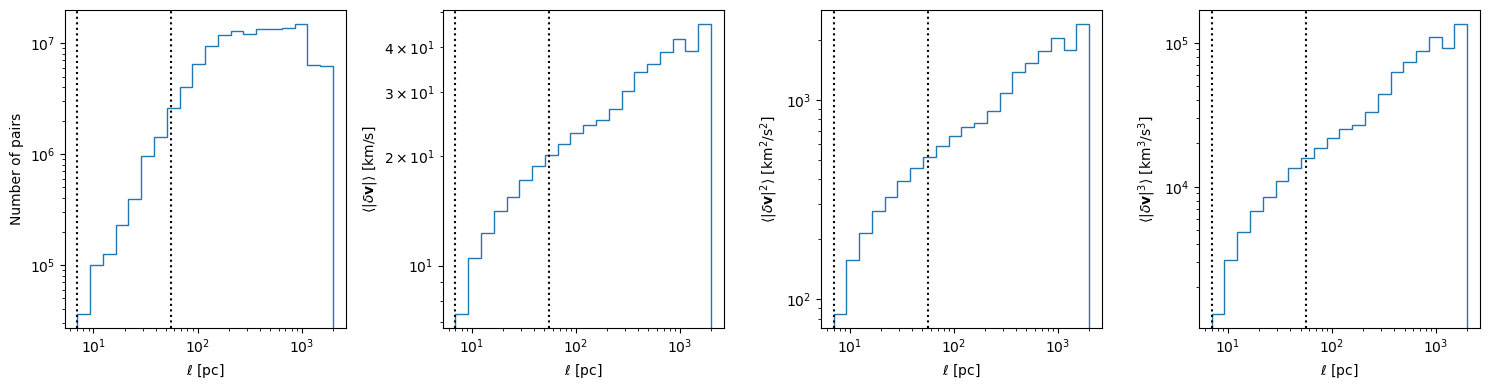

In [5]:
def randomly_select(
    data, maxpoints=1000, pos_units="pc", vel_units="cm/s", dens_units="g/cm**3"
):
    """
    Returns arrays of positions and velocities that can be
    used with velocity structure function

    Parameters
    ----------
    data
        This is the data source. This is like one of the objects you
        would get with yt from calling ds.all_data() or ds.cut_region()
    """
    # initial number of points (without randomly sampling)
    npoints = data["index", "x"].size
    # print(npoints)

    if maxpoints >= npoints:
        idx = slice(None)
    else:
        idx = np.random.permutation(npoints)[: int(maxpoints)]

    pos = np.array(
        [data["index", ii][idx].to("pc").ndarray_view() for ii in ["x", "y", "z"]]
    )
    vel = np.array(
        [
            data["gas", "velocity_" + ii][idx].to(vel_units).ndarray_view()
            for ii in ["x", "y", "z"]
        ]
    )
    dens = data["gas", "density"][idx].to("g/cm**3").ndarray_view()
    return pos, vel, dens


pos, vel, dens = randomly_select(
    ds.all_data(),
    maxpoints=100000,
    pos_units="pc",
    vel_units="km/s",
    dens_units="g/cm**3",
)
print(pos.shape)

# you might want to do this to avoid running out of memory
# ds.index.clear_all_data()

dist_bin_edges = np.geomspace(7.0, 2000.0, num=21)

vsf_result_dict = vsf_props(
    pos_a=pos,
    pos_b=None,
    val_a=vel,
    val_b=None,
    dist_bin_edges=dist_bin_edges,
    stat_kw_pairs=[("omoment3", {})],
    nproc=10,
)[0]

fig, ax_arr = plt.subplots(1, 4, figsize=(15, 4), sharex=True)

ax_arr[0].stairs(result_dict["counts"], edges=dist_bin_edges)
ax_arr[0].set_ylabel("Number of pairs")
ax_arr[1].stairs(result_dict["mean"], edges=dist_bin_edges)
ax_arr[1].set_ylabel(r"$\langle|\delta{\bf v}|\rangle$ [${\rm km}/{\rm s}$]")
ax_arr[2].stairs(result_dict["omoment2"], edges=dist_bin_edges)
ax_arr[2].set_ylabel(r"$\langle|\delta{\bf v}|^2\rangle$ [${\rm km}^2/{\rm s}^2$]")
ax_arr[3].stairs(result_dict["omoment3"], edges=dist_bin_edges)
ax_arr[3].set_ylabel(r"$\langle|\delta{\bf v}|^3\rangle$ [${\rm km}^3/{\rm s}^3$]")

for ax in ax_arr:
    ax.set_xlabel(r"$\ell\ [{\rm pc}]$")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.axvline(56, ls=":", color="k", label="initial radius")
    ax.axvline(56 / 8, ls=":", color="k", label="pixel scale")

fig.tight_layout()

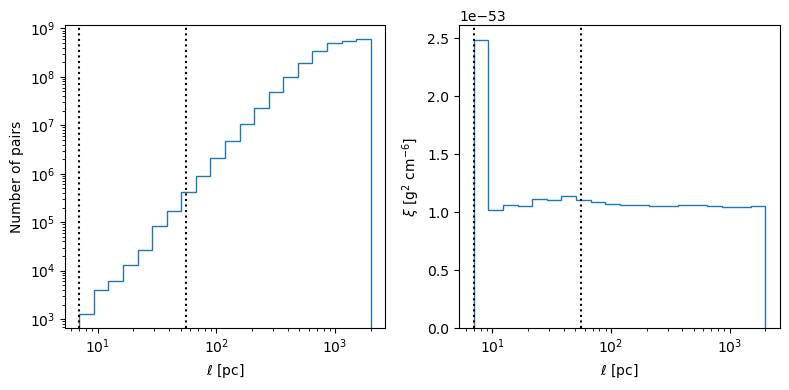

In [6]:
corr_result_dict = twopoint_correlation(
    pos_a=pos,
    val_a=dens,
    pos_b=None,
    val_b=None,
    dist_bin_edges=dist_bin_edges,
    stat_kw_pairs=[("mean", {})],
    nproc=10,
)[0]

fig, ax_arr = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

ax_arr[0].stairs(corr_result_dict["counts"], edges=dist_bin_edges)
ax_arr[0].set_ylabel("Number of pairs")
ax_arr[0].set_yscale("log")
ax_arr[1].stairs(corr_result_dict["mean"], edges=dist_bin_edges)
ax_arr[1].set_ylabel(r"$\xi\ [{\rm g}^2\ {\rm cm}^{-6}]$ ")

for ax in ax_arr:
    ax.set_xlabel(r"$\ell\ [{\rm pc}]$")
    ax.set_xscale("log")
    ax.axvline(56, ls=":", color="k", label="initial radius")
    ax.axvline(56 / 8, ls=":", color="k", label="pixel scale")

fig.tight_layout()